In [1]:
# Marketing Performance Analyst Project: End-to-End Pipeline

# ROAS and KPI analysis
# Conversion prediction using XGBoost
# Customer segmentation with PCA + K-Means
# ROI simulation at different budget levels
# Visualizations and executive insights

In [7]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Step 2: Load dataset
df = pd.read_csv(r"D:\JOB\5 Performance analyst\3 Marketing performance analyst\marketing_performance_dataset.csv")

In [9]:
df

,customer_id,campaign,channel,customer_segment,budget,clicks,impressions,conversions,customer_acquisition_cost,revenue_generated,roas
0,1,Campaign_C,Search Ads,Loyal Customer,7569.94,52,983,0,19.14,11.19,0.00
1,2,Campaign_D,Display Ads,Returning Customer,1541.89,48,993,0,90.26,824.06,0.53
2,3,Campaign_A,Search Ads,New Customer,8703.57,60,993,0,27.96,631.37,0.07
3,4,Campaign_C,Display Ads,Returning Customer,6468.91,50,981,1,43.00,1004.04,0.16
4,5,Campaign_C,Display Ads,Loyal Customer,2371.24,70,1000,0,85.62,1346.67,0.57
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,Campaign_D,Email,New Customer,1773.03,48,964,0,50.23,178.86,0.10
9996,9997,Campaign_C,Email,Loyal Customer,7077.54,39,1036,1,64.01,817.32,0.12
9997,9998,Campaign_B,Email,New Customer,7440.19,52,1004,0,28.84,456.15,0.06
9998,9999,Campaign_B,Display Ads,Loyal Customer,8880.11,36,981,0,76.86,1224.50,0.14


In [10]:
# Step 3: Feature Engineering
df['ctr'] = (df['clicks'] / df['impressions']).round(3)
df['cpc'] = (df['budget'] / df['clicks']).replace([np.inf, -np.inf], np.nan).fillna(0).round(2)
df['conversion_rate'] = df['conversions']  # binary column already (0 or 1)


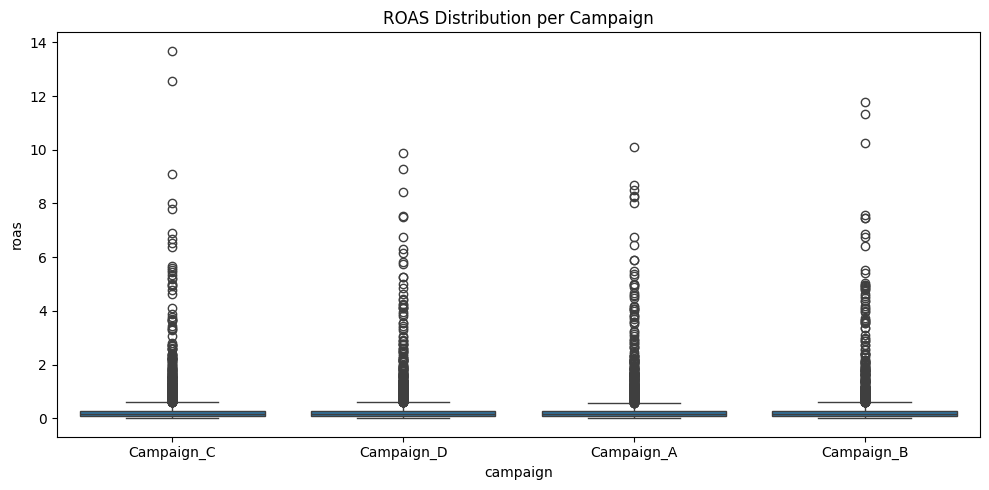

In [11]:
# Step 4: Campaign-level ROAS visualization
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='campaign', y='roas')
plt.title("ROAS Distribution per Campaign")
plt.tight_layout()
plt.show()

In [12]:
# Step 5: Predicting Conversion Likelihood
# Encode categorical features
df_encoded = pd.get_dummies(df, columns=['campaign', 'channel', 'customer_segment'], drop_first=True)


In [13]:
# Define features and target
X = df_encoded.drop(columns=['customer_id', 'conversions', 'revenue_generated'])
y = df_encoded['conversions']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [14]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1727
           1       1.00      1.00      1.00       273

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC Score: 1.0


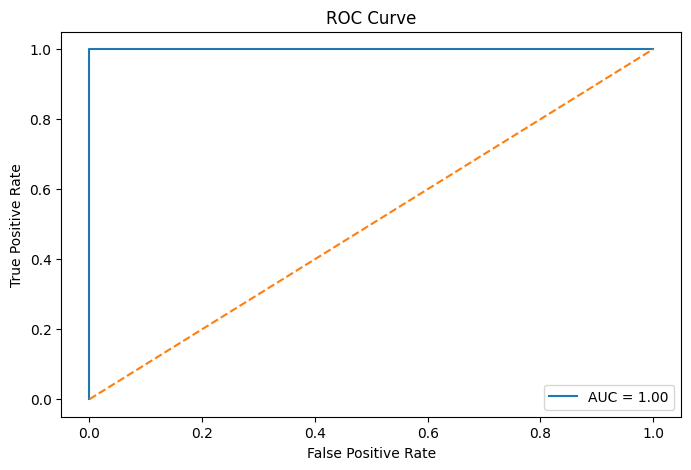

In [15]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.2f}')
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

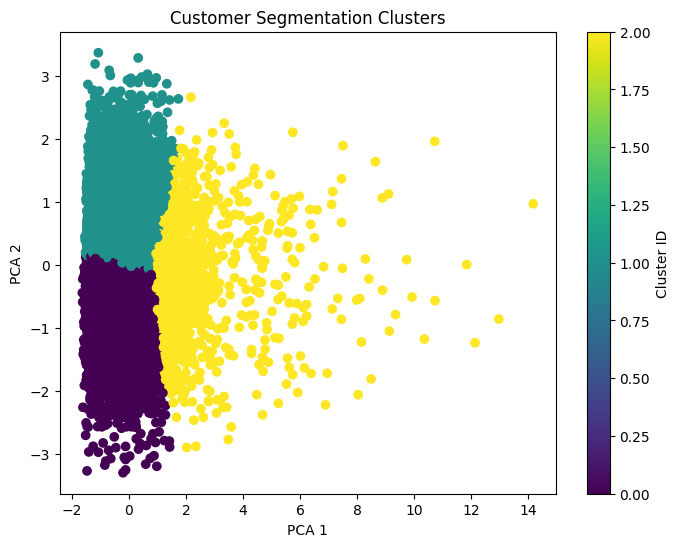

In [16]:
# Step 6: Customer Segmentation (K-Means + PCA)
seg_features = df[['budget', 'clicks', 'impressions', 'customer_acquisition_cost', 'roas']]
scaler = StandardScaler()
scaled = scaler.fit_transform(seg_features)

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled)

kmeans = KMeans(n_clusters=3, random_state=42)
k_labels = kmeans.fit_predict(reduced)

# Visualize clusters
plt.figure(figsize=(8,6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=k_labels, cmap='viridis')
plt.title("Customer Segmentation Clusters")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Cluster ID')
plt.show()


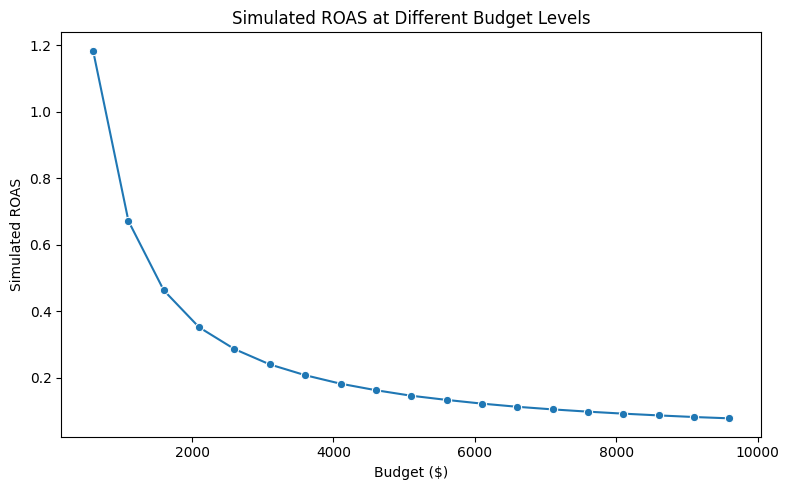

In [17]:
# Step 7: Simulate ROI at Different Budget Levels
budgets = np.arange(100, 10000, 500)
sim_results = []
for b in budgets:
    avg_revenue = df[df['budget'] <= b]['revenue_generated'].mean()
    avg_roas = avg_revenue / b if b > 0 else 0
    sim_results.append((b, avg_roas))

sim_df = pd.DataFrame(sim_results, columns=['budget', 'simulated_roas'])

# Visualize Simulation
plt.figure(figsize=(8,5))
sns.lineplot(data=sim_df, x='budget', y='simulated_roas', marker='o')
plt.title("Simulated ROAS at Different Budget Levels")
plt.xlabel("Budget ($)")
plt.ylabel("Simulated ROAS")
plt.tight_layout()
plt.show()

In [18]:
# Step 8: Executive Summary
print("--- Executive Summary ---")
print("Best performing campaigns by ROAS:")
print(df.groupby('campaign')['roas'].mean().sort_values(ascending=False).head(3))

print("\nMost responsive customer segments (conversion rate):")
print(df.groupby('customer_segment')['conversions'].mean().sort_values(ascending=False))

print("\nMarketing ROI Simulation Suggests Optimal Budget Range Between $2000–$5000")

--- Executive Summary ---
Best performing campaigns by ROAS:
campaign
Campaign_A    0.335016
Campaign_C    0.328926
Campaign_B    0.327961
Name: roas, dtype: float64

Most responsive customer segments (conversion rate):
customer_segment
Returning Customer    0.152007
New Customer          0.151035
Loyal Customer        0.149639
Name: conversions, dtype: float64

Marketing ROI Simulation Suggests Optimal Budget Range Between $2000–$5000
